In [1]:
import sys; sys.path.append('/rds/general/user/cb2714/home/wwa/'); from wwa import *

In [6]:
def synth_plot(df, ax = None, logged = False, split_uw = False):
    
    # set split_uw = True to plot the unweighted mean of obs and models on its own line
    if not ax: fig, ax = plt.subplots(dpi = 100)
    
    gcols = {"obs" : "blue", 
             "obs_synth" : "blue", 
             "models" : "red", 
             "model_synth" : "red",
             "synth" : "magenta"}
    
    ylabels = df.model.to_list()
    
    ax.grid(axis = "x", which = "major", color = "k", alpha = 0.1)
    
    if logged:
        ax.set_xscale('log')
        ax.axvline(1, ls = "--", color = "k", zorder = -99)
    else:
        ax.axvline(0, ls = "--", color = "k", zorder = -99)
    
    for k in range(len(df)):

        r = df.iloc[k]
        ax.add_patch(Rectangle((r.lower,-k-0.4), r.upper - r.lower, 0.8, facecolor = gcols[r.name], alpha = 0.5 + 0.5*("synth" in r.name)))
        ax.plot(r.est, -k, color = "k", marker = "v")
        
        if not (split_uw and df.index[k] == "synth"): 
            ax.add_patch(Rectangle((r.l_wb,-k-0.4), r.u_wb - r.l_wb, 0.8, edgecolor = "k", facecolor = "none", lw = 1.5))
        else:
            k = k+1
            ax.add_patch(Rectangle((r.l_wb,-k-0.4), r.u_wb - r.l_wb, 0.8, edgecolor = "k", facecolor = "none", lw = 1.5))
            if logged:
                uw_mean = np.exp((np.log(df.loc["obs_synth", "est"]) + np.log(df.loc["model_synth", "est"])) / 2)
            else:
                uw_mean = (df.loc["obs_synth", "est"] + df.loc["model_synth", "est"]) / 2
            ax.plot(uw_mean, -k, color = "k", marker = "v")
            ylabels = ylabels + ["unweighted mean"]

    ax.set_yticks(range(0, -len(ylabels), -1))
    ax.set_yticklabels(ylabels)

# Summaries for 10year study

In [56]:
# load data

rnm = "Sidr-2007"

di, pr = [pd.read_fwf(rnm+"_"+x+".txt", comment = "#", widths = [5,5,12,12,12,12,12,4,99], header = None,
            names = ["ystart", "yend", "est", "lower", "upper", "l_wb", "u_wb", "group", "model"]) for x in ["dI", "PR"]]

di_lim = {"synthnew2013-rx4day" : (-50,100), "synthnew2024-rx4day" : (-50,100),
          "Nargis-2008" : (-100, 200), "Nargis-2024" : (-100, 200),
           "Sidr-2007" : (-100, 200), "Sidr-2024" : (-100, 200),
         }[rnm]

pr_lim = {"synthnew2013-rx4day" : (1e-3,1e7), "synthnew2024-rx4day" : (1e-3,1e7),
          "Nargis-2008" : (1e-3, 1e5), "Nargis-2024" : (1e-3, 1e5),
          "Sidr-2007" : (1e-1, 1e2), "Sidr-2024" : (1e-1, 1e2),
         }[rnm]

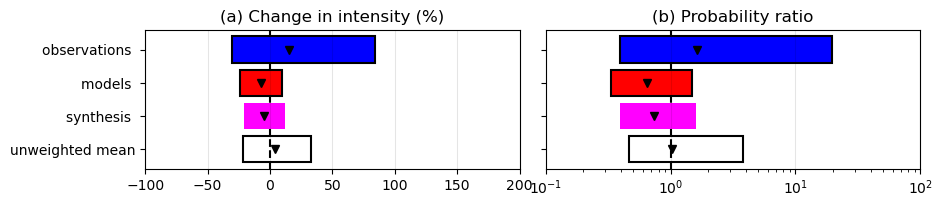

In [57]:
# fix group & model names
groups = [["obs","obs_synth","models","model_synth","synth"][i-1] for i in di.group]
di.index = groups; pr.index = groups

models = [re.sub("ETH-","",re.sub("UGent-","",re.sub("rcp85 r[0-9]+i1p1 ", "", re.sub(" \(1\) ","",re.sub('"','',m))))) for m in pr.model]
di["model"] = models; pr["model"] = models

# trim down to just the summary rows
di, pr = [df.loc[["synth" in r for r in di.index]] for df in [di, pr]]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig, axs = plt.subplots(ncols = 2, sharey = True, figsize = (10,len(di)*0.6), dpi = 100)
plt.subplots_adjust(wspace = 0.07)

synth_plot(di, ax = axs[0], split_uw = True)
axs[0].set_title("(a) Change in intensity (%)")
axs[0].set_xlim(di_lim)

synth_plot(pr, ax = axs[1], logged = True, split_uw = True)
axs[1].set_title("(b) Probability ratio")
axs[1].set_xlim(pr_lim)

# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# # add extra row for future

# load future changes
# fdi, fpr = [pd.read_fwf(rnm+"_"+x+"_future.txt", comment = "#", widths = [5,5,12,12,12,12,12,4,99], header = None,
#             names = ["ystart", "yend", "est", "lower", "upper", "l_wb", "u_wb", "group", "model"]).iloc[-1] for x in ["dI", "PR"]]

# k = len(di)+2
# axs[0].add_patch(Rectangle((fdi.l_wb,-k-0.4), fdi.u_wb - fdi.l_wb, 0.8, edgecolor = "k", facecolor = "red", lw = 1.5))
# axs[0].plot(fdi.est, -k, color = "k", marker = "v")

# axs[1].add_patch(Rectangle((fpr.l_wb,-k-0.4), fpr.u_wb - fpr.l_wb, 0.8, edgecolor = "k", facecolor = "red", lw = 1.5))
# axs[1].plot(fpr.est, -k, color = "k", marker = "v")

# axs[0].set_yticks(range(0,-len(di)-3,-1))
# axs[0].set_yticklabels(["Observations", "Models", "Weighted synthesis", "Unweighted synthesis", "", "Future (models only)"])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plt.savefig("minisynthesis_"+rnm+".png")

# Produce synthesis from text files

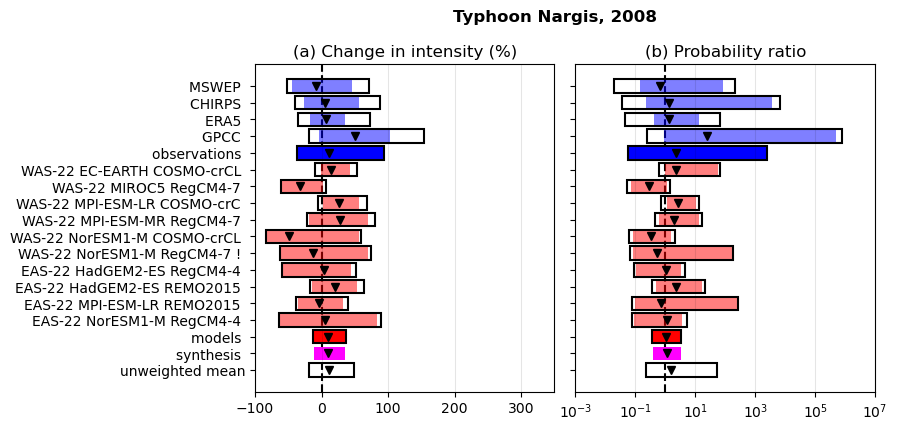

In [113]:
# load data

tc = "Nargis"; y = "2008"

di, pr = [pd.read_fwf(x+"_"+tc+"_"+y+".txt", comment = "#", widths = [5,5,12,12,12,12,12,4,99], header = None,
            names = ["ystart", "yend", "est", "lower", "upper", "l_wb", "u_wb", "group", "model"]) for x in ["INT", "PR"]]

# fix group & model names
groups = [["obs","obs_synth","models","model_synth","synth"][i-1] for i in di.group]
di.index = groups; pr.index = groups

models = [re.sub("ETH-","",re.sub("UGent-","",re.sub("rcp85 r[0-9]+i1p1 ", "", re.sub(" \(1\) ","",re.sub('"','',m))))) for m in pr.model]
di["model"] = models; pr["model"] = models

fig, axs = plt.subplots(ncols = 2, sharey = True, figsize = (8,len(di)*0.25))
plt.subplots_adjust(wspace = 0.07)

synth_plot_uw(di, ax = axs[0], uw = True)
axs[0].set_title("(a) Change in intensity (%)")
axs[0].set_xlim({"Sidr" : (-100,350), "Nargis" : (-100,350)}[tc])

synth_plot_uw(pr, ax = axs[1], logged = True, uw = True)
axs[1].set_title("(b) Probability ratio")
axs[1].set_xlim({"Sidr" : (0.1,10e4), "Nargis" : (0.001, 10e6)}[tc])

plt.suptitle("Typhoon "+tc+", "+y, fontweight = "bold", y = 1.01)
plt.savefig("synthesis_"+tc+"_"+y+".png")